In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from pypika import Table, CustomFunction
from pypika.dialects import MSSQLQuery

from astroquery.gaia import Gaia

pd.set_option('display.max_columns', None)

In [2]:
def queryStarsFromHipparcos():
    src = Table("public.hipparcos")

    q = MSSQLQuery \
        .from_(src) \
        .select(src.hip, src.rahms, src.dedms, src.plx, src.vmag,
                src.b_v, src.sptype) 

    query_sql = q.get_sql() 
    query_sql = query_sql.replace('"', '')                       # Remove "" around any select
    
    job = Gaia.launch_job_async(query_sql)
    results = job.get_results()
    
    df = results.to_pandas()
    
    df = df.rename(columns={"plx": "parallax", "vmag": "apparent_mag", "sptype":"spectral_type"})
    
    return df

In [3]:
# Query
df = queryStarsFromHipparcos()

# convert to floats
df['apparent_mag'] = df['apparent_mag'].astype(np.float64)
df['parallax'] = df['parallax'].astype(np.float64)

# Drop Nan
df = df.dropna()

# Drop negative or zero parallax
df = df.drop(df.index[df['parallax'] <= 0])

# Filter to entries with common spectral types
df = df.drop(df.index[df['spectral_type'] == ''])
#df = df[df['spectral_type'].map(lambda s: s[0] in 'OBAFGKMLSCD')]
df = df[df['spectral_type'].map(lambda s: s[0] in 'OBAFGKMD')]

# Add distance
df['distance'] = df['parallax'].map(lambda x: (x*u.mas).to(u.parsec, equivalencies=u.parallax()).value)

# Add absolute magnitude
df['absolute_mag'] = df['apparent_mag'] - 5*np.log10(df['distance']/10.0)

# Add Teff
df["Teff"] = pd.Series(4600 * (1/(.92 * df["b_v"] + 1.7) + 1/(.92 * df["b_v"] + .62)))


INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
color_mapping = {
    'O': 'cyan',
    'B': 'blue',
    'A': 'green',
    'F': 'olive',
    'G': 'yellow',
    'K': 'orange',
    'M': 'red',
#    'L': 'black',
#    'S': 'purple',
#    'C': 'gold',
    'D': 'violet'
}

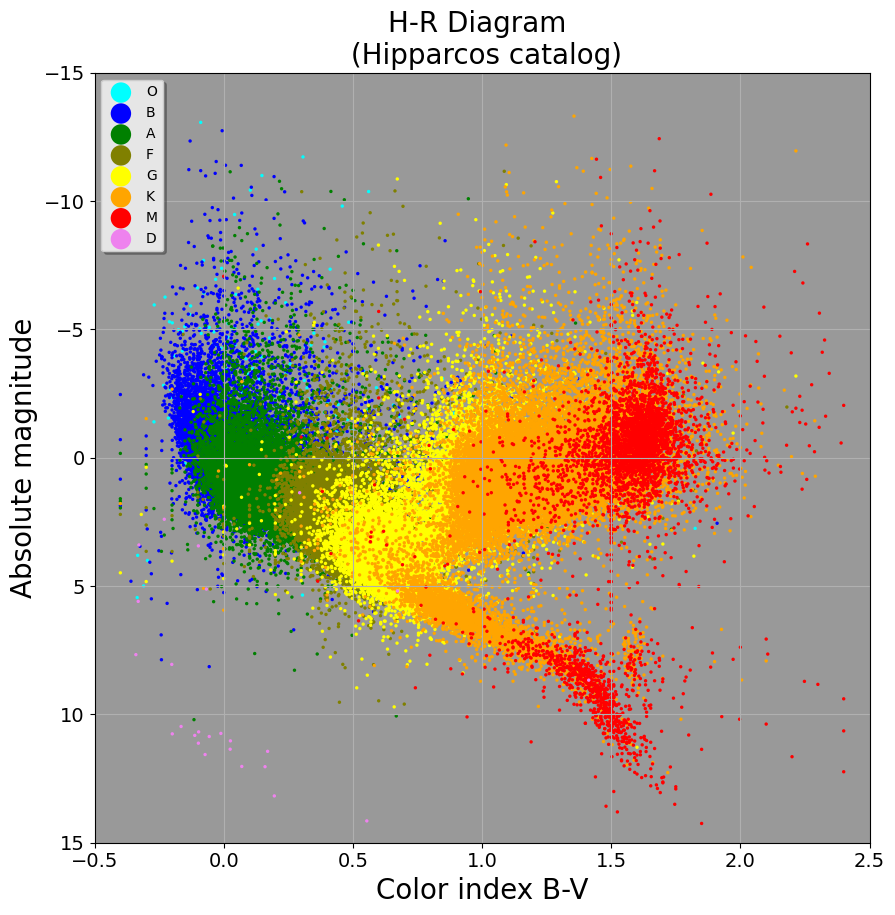

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, facecolor='0.6')

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(15, -15)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.title.set_fontsize(20)
ax.set_xlabel('Color index B-V')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Absolute magnitude')
ax.yaxis.label.set_fontsize(20)

for spectral_type, color in color_mapping.items():
    f = lambda s: s[0]==spectral_type
    ix = df['spectral_type'].map(f)
    ax.scatter(df['b_v'][ix], df['absolute_mag'][ix], c = color, s=6, edgecolors='none', label = spectral_type)

ax.tick_params(axis='both', labelsize=14)
legend = ax.legend(scatterpoints=1,markerscale = 6, shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')

In [6]:
# Filter to Main Sequence only
f = lambda s: ('V' in s) and ('VI' not in s) and ('IV' not in s)
idx  = df['spectral_type'].apply(f)
df_main_seq = df[idx]

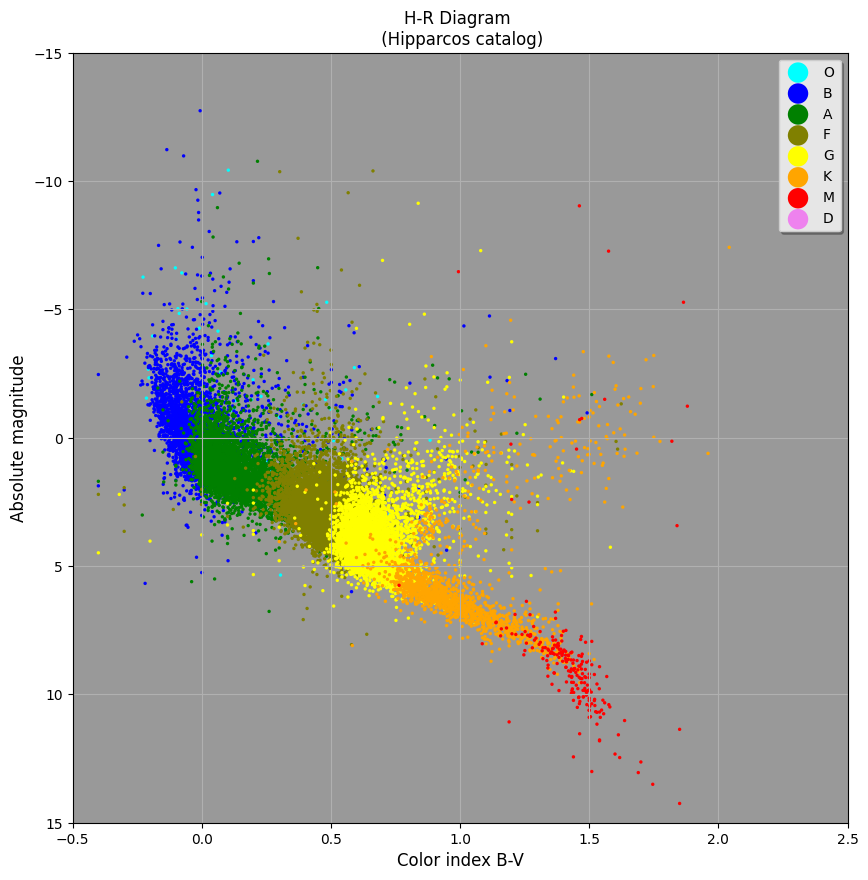

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, facecolor='0.6')

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(15, -15)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.title.set_fontsize(12)
ax.set_xlabel('Color index B-V')
ax.xaxis.label.set_fontsize(12)
ax.set_ylabel('Absolute magnitude')
ax.yaxis.label.set_fontsize(12)

for spectral_type, color in color_mapping.items():
    f = lambda s: s[0]==spectral_type
    ix = df['spectral_type'].map(f)
    ax.scatter(df_main_seq['b_v'][ix], df_main_seq['absolute_mag'][ix], c = color, s=6, edgecolors='none', label = spectral_type)

ax.tick_params(axis='both', labelsize=10)
legend = ax.legend(scatterpoints=1,markerscale = 6, shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')